In [46]:
ls

Untitled.ipynb
__pycache__/
centroids_information.pkl
clusters_exploration_COMA_intero.ipynb
clusters_exploration_COMA_new_ground_truth.ipynb
clusters_exploration_new_dataset.ipynb
clusters_renderings/
data/
data_old/
explore_train_space.ipynb
final_clusters_exploration_COMA_TOP-new_GT.ipynb
final_clusters_exploration_COMA_TOP.ipynb
final_clusters_exploration_COMA_intero.ipynb
final_clusters_exploration_COMA_intero_new_GT.ipynb
fix_test_train.ipynb
new_ground_truth_clusters.ipynb
out_prova.png
outliars_renderings/
reference_meshes/
render_clusters.py
render_outliers.py
render_videos.py
rendering_utils.py
sample_convex_hull.ipynb
videos/


In [47]:
import pandas as pd
import numpy as np
import hdbscan
import umap
import seaborn as sns
sns.set(rc={'figure.figsize':(9,8)})

In [3]:
#!pip install hdbscan
#!pip install umap-learn

In [4]:
test_df = pd.read_csv("data/filtri_coma/vanilla/test_metadata.csv")
train_df = pd.read_csv("data/filtri_coma/vanilla/train_metadata.csv")
test_latents = np.load("data/filtri_coma/vanilla/latents_test.npy")
train_latents = np.load("data/filtri_coma/vanilla/latents_train.npy")

In [5]:
test_df = pd.read_csv("data/filtri_coma_top/vanilla/test_metadata.csv")
train_df = pd.read_csv("data/filtri_coma_top/vanilla/train_metadata.csv")
test_latents = np.load("data/filtri_coma_top/vanilla/latents_test.npy")
train_latents = np.load("data/filtri_coma_top/vanilla/latents_train.npy")

In [2]:
test_df = pd.read_csv("data/filtri_coma/vanilla/test_metadata.csv")
train_df = pd.read_csv("data/filtri_coma/vanilla/train_metadata.csv")
test_latents = np.load("data/filtri_coma/new_gt/latents_test.npy")
train_latents = np.load("data/filtri_coma/new_gt/latents_train.npy")

In [48]:
test_df = pd.read_csv("data/filtri_coma_top/vanilla/test_metadata.csv")
train_df = pd.read_csv("data/filtri_coma_top/vanilla/train_metadata.csv")
test_latents = np.load("data/filtri_coma_top/new_gt/latents_test.npy")
train_latents = np.load("data/filtri_coma_top/new_gt/latents_train.npy")

In [49]:
print(f"Test latents shape: {test_latents.shape}, train latents shape: {train_latents.shape}")

Test latents shape: (4234, 16), train latents shape: (16231, 16)


In [50]:
print(f"Test dataframe shape: {test_df.shape}, train dataframe shape: {train_df.shape}")
assert test_df.shape[0] == test_latents.shape[0]
assert train_df.shape[0] == train_latents.shape[0]

Test dataframe shape: (4234, 6), train dataframe shape: (16231, 6)


In [51]:
test_df.iloc[[5]]

,Unnamed: 0,individual_id,expression_id,individual_name,expression_name,mesh_file_name
5,5,0,0,FaceTalk_170725_00137_TA,bareteeth,bareteeth.000006.ply


In [52]:
#train_df.iloc[[5]]
all_df = pd.concat([train_df, test_df])

In [53]:
all_df.shape

(20465, 6)

In [54]:
#all_df.tail(10)

In [55]:
all_latents = np.vstack((train_latents, test_latents))

In [56]:
assert (all_latents[1] == train_latents[1]).all()

I do clustering here, instead of loading preprocessed data

Silhouette method for number of clusters

In [57]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm import tqdm

In [14]:
calculate_num_clusters = False
if calculate_num_clusters:
    sil = []
    kmax = 150

    Sum_of_squared_distances = [] #for elbow method
    ks = range(2, kmax+1)
    # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
    for k in tqdm(ks):
      kmeans = KMeans(n_clusters = k).fit(all_latents)
      labels = kmeans.labels_
      sil.append(silhouette_score(all_latents, labels, metric = 'euclidean'))
      Sum_of_squared_distances.append(kmeans.inertia_) #for elbow method

In [15]:
max(labels)
plt.plot(range(2, kmax+1),sil, scalex=True, scaley=True, data=None)
plt.title("Silouhette score")


NameError: name 'labels' is not defined

In [198]:
#cluster = KMeans(n_clusters = 12).fit(all_latents)


In [199]:
#from sklearn.mixture import GaussianMixture
# Suppose Data X is a 2-D Numpy array (One apple has two features, size and flavor)
#cluster = GaussianMixture(n_components=12, random_state=0).fit(all_latents)

Elbow method for number of clusters

In [200]:
len(Sum_of_squared_distances)

NameError: name 'Sum_of_squared_distances' is not defined

In [201]:
len(ks)

NameError: name 'ks' is not defined

In [19]:

plt.plot(ks, Sum_of_squared_distances)
#plt.plot(range(2, kmax+1),Sum_of_squared_distances, scalex=True, scaley=True, data=None)

plt.xlabel("Values of K") 
plt.ylabel("Sum of squared distances/Inertia") 
plt.title("Elbow Method For Optimal k")
plt.show()

NameError: name 'plt' is not defined

In [58]:
cluster = hdbscan.HDBSCAN(min_cluster_size=150,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(all_latents)
#for now it was trial and error, however the correct "minclustersize" can be calculated using some trials

In [59]:
minimum_cluster_size = 50
first = True
while max(cluster.labels_) > 11 or first: #12 is the number of individuals
    first = False
    minimum_cluster_size += 1 
    cluster = hdbscan.HDBSCAN(min_cluster_size=minimum_cluster_size,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(all_latents)
    print(f"{minimum_cluster_size} -> {max(cluster.labels_)}")

51 -> 12
52 -> 12
53 -> 12
54 -> 12
55 -> 12
56 -> 11


In [60]:
max(cluster.labels_)

11

In [61]:
import matplotlib.pyplot as plt
import umap.umap_ as umap
import seaborn as sns

def plotClustersSns(funClusters, latents):
    umap_data = umap.UMAP(n_neighbors=100, n_components=2, min_dist=0.0, metric='cosine').fit_transform(latents)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = funClusters.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(10, 7))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    #plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
    #plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
    sns.scatterplot(data=clustered, x="x", y="y", hue=clustered.labels)
    #plt.colorbar()
    plt.title("Visualization of one instance of clustering through HDBSCAN")

In [62]:
import matplotlib.pyplot as plt
import umap.umap_ as umap
def plotClusters(funClusters, latents):
    umap_data = umap.UMAP(n_neighbors=100, n_components=2, min_dist=0.0, metric='cosine').fit_transform(latents)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = funClusters.labels_

    # Visualize clusters
    fig, ax = plt.subplots(figsize=(10, 7))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
    plt.colorbar()
    plt.title("Visualization of one instance of clustering through HDBSCAN")

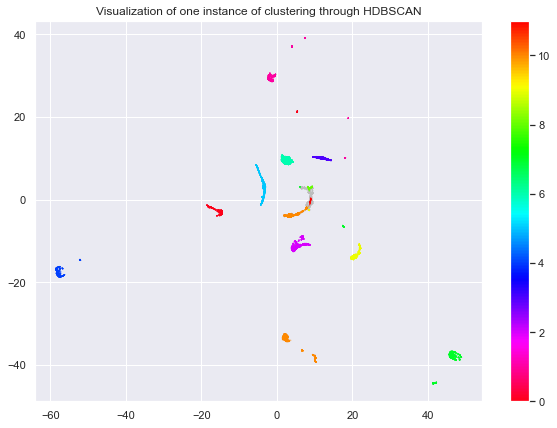

In [63]:
plotClusters(cluster, all_latents)

Now I try clustering with dimensionality reduction

In [64]:
'''umap_embeddings = umap.UMAP(n_neighbors=100, 
                            n_components=5, 
                            metric='cosine').fit_transform(all_latents)

cluster = hdbscan.HDBSCAN(min_cluster_size=60,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)'''

"umap_embeddings = umap.UMAP(n_neighbors=100, \n                            n_components=5, \n                            metric='cosine').fit_transform(all_latents)\n\ncluster = hdbscan.HDBSCAN(min_cluster_size=60,\n                          metric='euclidean',                      \n                          cluster_selection_method='eom').fit(umap_embeddings)"

In [65]:
max(cluster.labels_)

11

**What is the algorithm clustering?**

**Q: if k = 12, or minimum cluster size is s.t. clusters = 12 in hdbscan, will the clusters correspond to the different individuals?**

In [66]:
#all_df.insert(1, "clust_labels", cluster.labels_)

In [67]:
all_df.tail(100)

,Unnamed: 0,individual_id,expression_id,individual_name,expression_name,mesh_file_name
4134,4134,2,11,FaceTalk_170731_00024_TA,mouth_up,mouth_up.000087.ply
4135,4135,2,11,FaceTalk_170731_00024_TA,mouth_up,mouth_up.000088.ply
4136,4136,2,11,FaceTalk_170731_00024_TA,mouth_up,mouth_up.000089.ply
4137,4137,2,11,FaceTalk_170731_00024_TA,mouth_up,mouth_up.000090.ply
4138,4138,2,11,FaceTalk_170731_00024_TA,mouth_up,mouth_up.000091.ply
...,...,...,...,...,...,...
4229,4229,2,11,FaceTalk_170731_00024_TA,mouth_up,mouth_up.000182.ply
4230,4230,2,11,FaceTalk_170731_00024_TA,mouth_up,mouth_up.000183.ply
4231,4231,2,11,FaceTalk_170731_00024_TA,mouth_up,mouth_up.000184.ply
4232,4232,2,11,FaceTalk_170731_00024_TA,mouth_up,mouth_up.000185.ply


In [68]:
clusters_lists = [set() for i in range(0, max(cluster.labels_)+1)]
individuals_lists = [set() for i in range(all_df["individual_id"].max()+1)]
#I want to make sets of clusters labels, individuals ids and more if necessary (e.g. expressions?)
individuals_ids = all_df["individual_id"].tolist()
for i in range(len(cluster.labels_)):
    if cluster.labels_[i] != -1:
        clusters_lists[cluster.labels_[i]].add(i)
    individuals_lists[individuals_ids[i]].add(i)

In [69]:
#individuals_lists[11]

In [70]:
max(cluster.labels_)

11

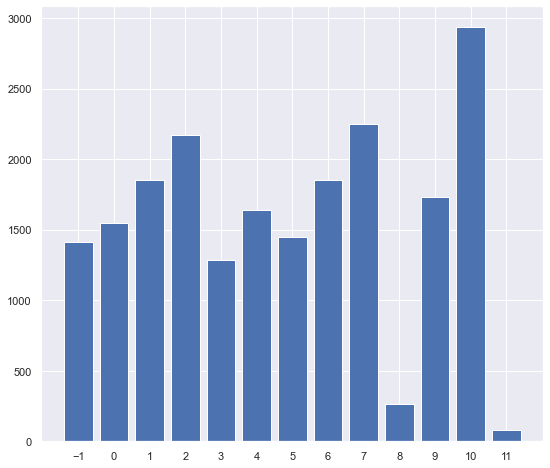

In [71]:
arr = np.array(cluster.labels_)

labels, counts = np.unique(arr, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

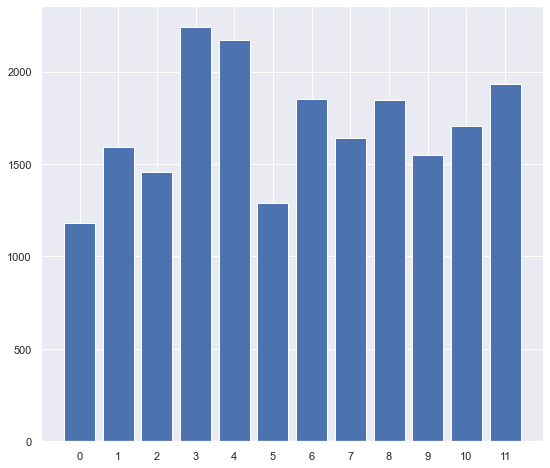

In [72]:
arr = np.array(individuals_ids)

labels, counts = np.unique(arr, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

In [73]:
IoUs = np.zeros((len(clusters_lists), len(individuals_lists)))

In [74]:
IoUs.shape

(12, 12)

In [75]:
for i in range(len(clusters_lists)):
    for j in range(len(individuals_lists)): 
        intersection = len(individuals_lists[j].intersection(clusters_lists[i]))
        union = len(individuals_lists[j].union(clusters_lists[i]))
        IoUs[i][j] = intersection/union
        #print(f"IoU {i,j} is {intersection/union}")


In [76]:
test_df.iloc[2000]
print(IoUs)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         1.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.         0.         0.         0.         0.        ]
 [0.         0.         0.99314129 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.        ]
 [0.         0.00260824 0.         0.99555753 0.         0.
  0.         0.         0.         0.

Text(58.5, 0.5, 'Cluster')

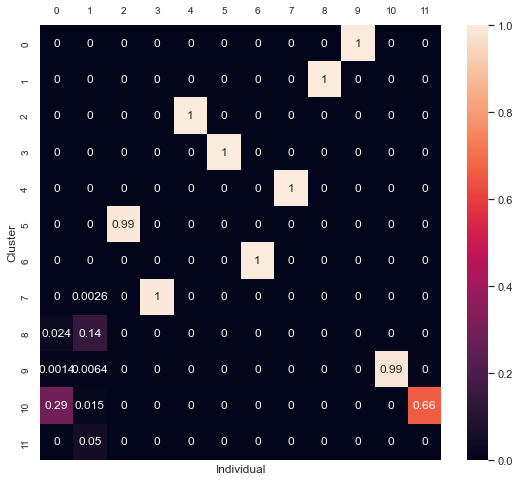

In [77]:
import seaborn as sns
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax = sns.heatmap(IoUs, annot=True)
ax.set_xlabel("Individual")
ax.set_ylabel("Cluster")

Another trial could be doing the percentage of "correct guesses" 
i.e. for each element of a cluster, check if the element is in the individuals set, if so, increment and calculate percentage

In [78]:
percentages = np.zeros((len(clusters_lists), len(individuals_lists)))
for i in range(len(clusters_lists)):
    for j in range(len(individuals_lists)): 
        for cluster_item in clusters_lists[i]:
            if cluster_item in individuals_lists[j]:
                percentages[i][j] += 1
        percentages[i][j] /= len(clusters_lists[i])
        


Text(58.5, 0.5, 'Cluster')

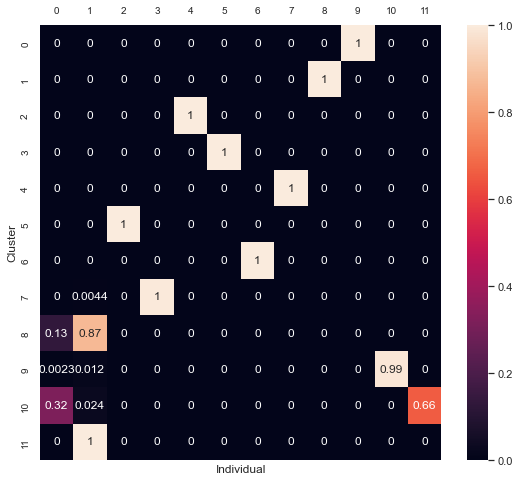

In [79]:
import seaborn as sns
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax = sns.heatmap(percentages, annot=True)
ax.set_xlabel("Individual")
ax.set_ylabel("Cluster")

In [80]:
clusters_lists = [set() for i in range(-1, max(cluster.labels_)+1)]
print(clusters_lists)

[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]


In [81]:
i = 0
for i in range(12): 
    print(len(clusters_lists[i]))

0
0
0
0
0
0
0
0
0
0
0
0


In [82]:
clusters_lists = [set() for i in range(-1, max(cluster.labels_)+1)]
individuals_lists = [set() for i in range(all_df["individual_id"].max()+1)]
#I want to make sets of clusters labels, individuals ids and more if necessary (e.g. expressions?)
individuals_ids = all_df["individual_id"].tolist()
for i in range(len(cluster.labels_)):
    #if cluster.labels_[i] != -1: here, I also want the outliars
    clusters_lists[cluster.labels_[i]].add(i)
    individuals_lists[individuals_ids[i]].add(i)

In [83]:
#clusters_lists[-1]

In [84]:
import copy

In [85]:
#percentages_inverse = np.zeros((len(clusters_lists), len(individuals_lists)))
percentages_inverse = np.zeros((len(individuals_lists), len(clusters_lists)))
ouliars_per_individual = list()

for i in range(len(individuals_lists)):
    temp = set()
    for j in range(len(clusters_lists)): 
        for individual in individuals_lists[i]:
            if individual in clusters_lists[j]:
                percentages_inverse[i][j] += 1
            if individual in clusters_lists[-1]:
                temp.add(individual)
        percentages_inverse[i][j] /= len(individuals_lists[i])
    ouliars_per_individual.append(copy.copy(list(temp)))

percentages_inverse = percentages_inverse.T
# fare queste percentuali è esattamente fare l'IoU

Text(58.5, 0.5, 'Cluster')

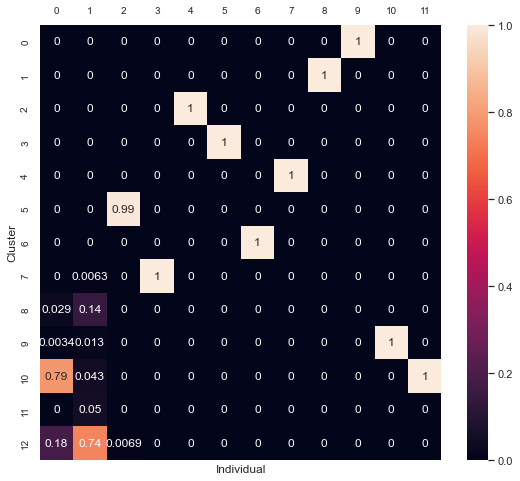

In [86]:
import seaborn as sns
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax = sns.heatmap(percentages_inverse, annot=True)
ax.set_xlabel("Individual")
ax.set_ylabel("Cluster")

In [87]:
item = all_df.iloc[[5]]['expression_name']
print("Hello " + item + " HI")
pippo = {}
pippo['a'] = 4
if pippo.get('a'):
    print("HI")

5    Hello bareteeth HI
Name: expression_name, dtype: object
HI


In [88]:
histograms = []
percentages = []
expressions = ['cheeks_in','eyebrow','high_smile','lips_back', 'lips_up','mouth_down','mouth_extreme','mouth_middle','mouth_open', 'mouth_side', 'mouth_up', 'bareteeth']
expressions_heatmap = np.zeros((len(individuals_lists), len(expressions)))

i = 0
for item in ouliars_per_individual:
    diz = {}
    diz_perc = {}
    j = 0
    for expression in expressions:
        diz[expression] = 0
        diz_perc[expression] = 0
        
    for outliar in item:
        diz[all_df.iloc[[outliar]]['expression_name'].values[0]] += 1
    
    for dict_item in diz: 
        if len(item) != 0:
            diz_perc[dict_item] = diz[dict_item]/len(item)
        #diz_perc['Size'] = len(item)
    percentages.append(copy.copy(diz_perc))
    histograms.append(copy.copy(diz))
    
    

<Figure size 1296x144 with 0 Axes>

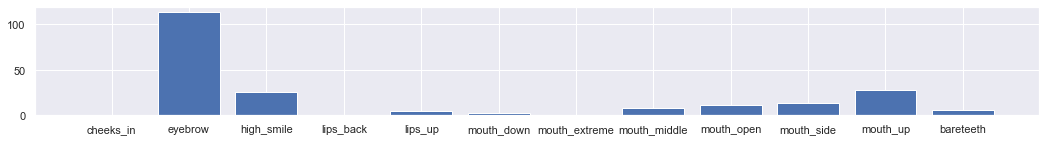

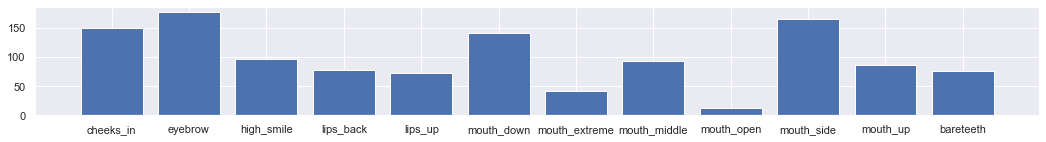

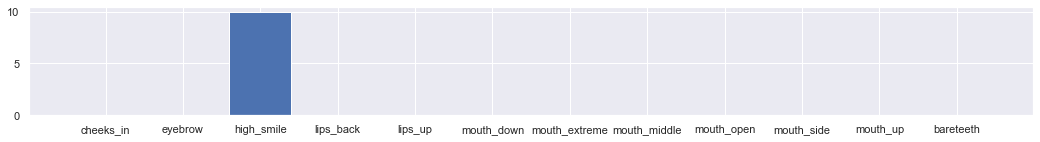

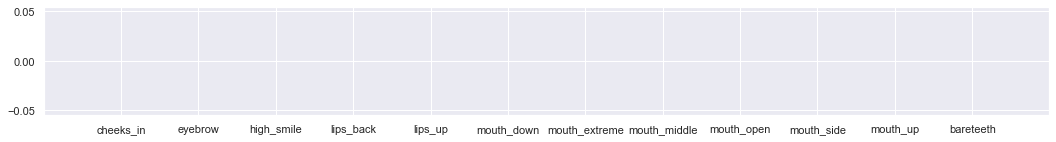

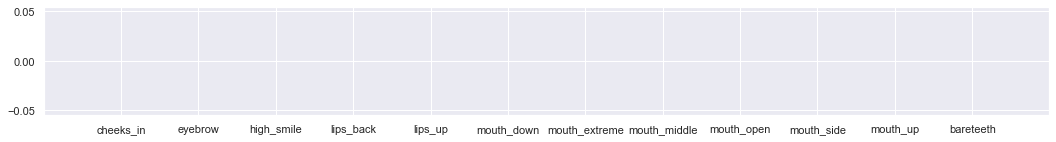

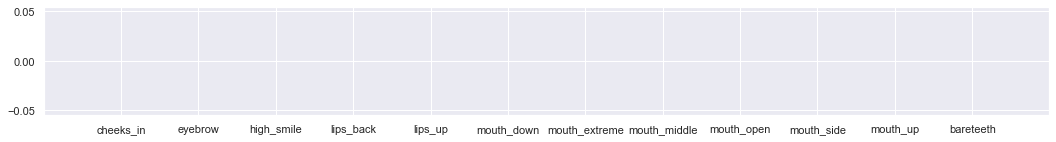

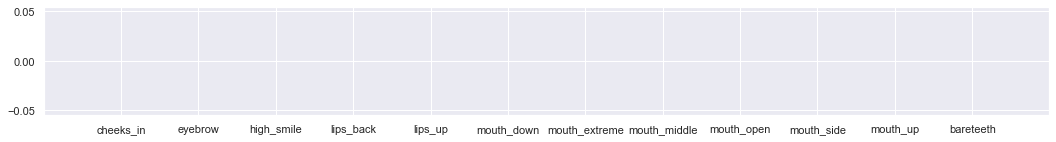

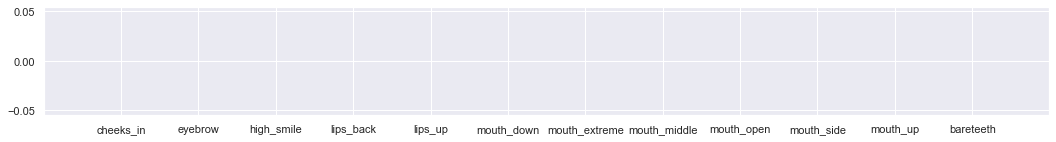

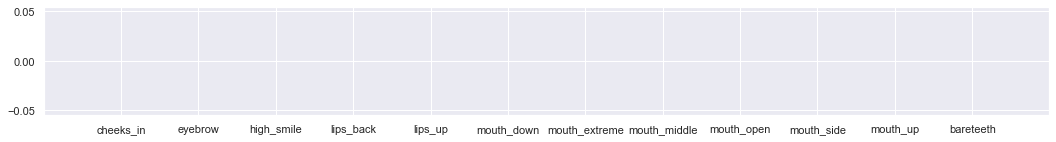

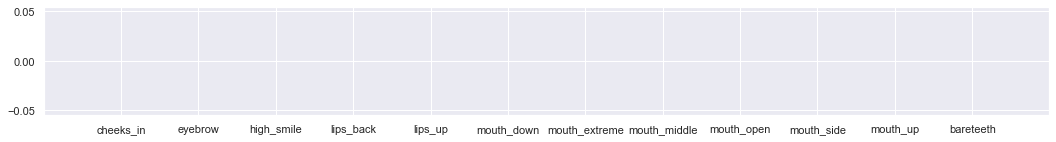

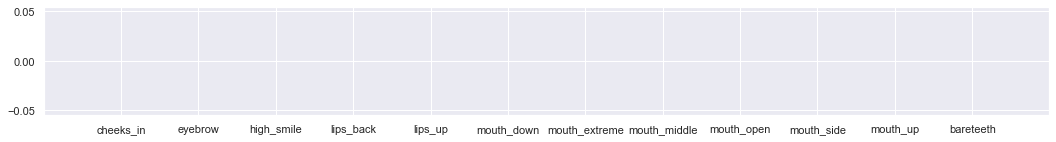

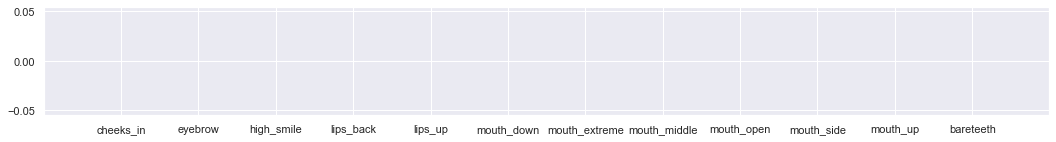

In [89]:
plt.figure(figsize=(18, 2))
for histogram in histograms:
    plt.figure(figsize=(18, 2))
    plt.bar(histogram.keys(), histogram.values())


Text(121.5, 0.5, 'Cluster')

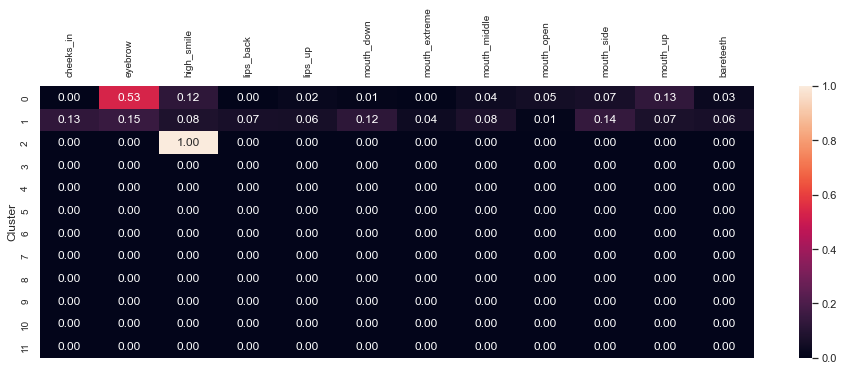

In [90]:
import seaborn as sns

df = pd.DataFrame.from_dict(percentages)
plt.figure(figsize = (16,5))

plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax = sns.heatmap(df, annot=True, fmt='.2f')
ax.set_ylabel("Cluster")


In [ ]:
import pickle

with open("data/filtri_coma/vanilla/outliars.pkl", 'wb') as file:
    pickle.dump(ouliars_per_individual, file)
    
with open("data/filtri_coma/vanilla/labels.pkl", 'wb') as file:
    pickle.dump(cluster.labels_, file)

### Constraining less the number of elements for HDBSCAN
What if each cluster, without constraining HDBSCAN's minimum number of elements for a cluster, is exactly the combination of an individual and one expression? 

In [ ]:
minimum_cluster_size = 20
first = True
while max(cluster.labels_) > 143 or first: #12 is the number of individuals
    first = False
    minimum_cluster_size += 1 
    cluster = hdbscan.HDBSCAN(min_cluster_size=minimum_cluster_size,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(all_latents)
    print(f"{minimum_cluster_size} -> {max(cluster.labels_)}")

In [ ]:
plotClusters(cluster, all_latents)

In [ ]:
#len(set((all_df['individual_id'].map(str) + "-" + all_df['expression_id'].map(str)).tolist()))

In [52]:
all_df = all_df.reset_index()

In [53]:
#all_df.index.tolist()[20000:]

In [54]:
sets_dict = {}
for i in range(all_df['individual_id'].nunique()):
    for j in range(all_df['expression_id'].nunique()): 
        sets_dict[str(i)+"-"+str(j)] = set((all_df.loc[all_df['individual_id'] == i].index).tolist()).intersection(set((all_df.loc[all_df['expression_id'] == j].index).tolist()))

#format: i-j => individual i and expression j
#print(sets_dict['3-0'])

#TODO: intersection over union and heatmap for each cluster

In [55]:
print(sets_dict)

{'0-0': {16231, 16232, 16233, 16234, 16235, 16236, 16237, 16238, 16239, 16240, 16241, 16242, 16243, 16244, 16245, 16246, 16247, 16248, 16249, 16250, 16251, 16252, 16253, 16254, 16255, 16256, 16257, 16258, 16259, 16260, 16261, 16262, 16263, 16264, 16265, 16266, 16267, 16268, 16269, 16270, 16271, 16272, 16273, 16274, 16275, 16276, 16277, 16278, 16279, 16280, 16281, 16282, 16283, 16284, 16285, 16286, 16287, 16288, 16289, 16290, 16291, 16292, 16293, 16294, 16295, 16296, 16297, 16298, 16299, 16300, 16301, 16302, 16303, 16304, 16305, 16306, 16307, 16308, 16309, 16310, 16311, 16312, 16313, 16314, 16315, 16316, 16317, 16318, 16319, 16320, 16321, 16322, 16323, 16324, 16325, 16326, 16327, 16328, 16329, 16330, 16331, 16332, 16333, 16334, 16335, 16336, 16337, 16338, 16339, 16340, 16341}, '0-1': {16384, 16385, 16386, 16387, 16388, 16389, 16390, 16391, 16392, 16393, 16394, 16395, 16396, 16397, 16398, 16399, 16400, 16401, 16402, 16403, 16404, 16405, 16406, 16407, 16408, 16409, 16410, 16411, 16412, 16

In [56]:
clusters_lists = [set() for i in range(max(cluster.labels_)+1)]
#I want to make sets of clusters labels, individuals ids and more if necessary (e.g. expressions?)
for i in range(len(cluster.labels_)):
    if cluster.labels_[i] != -1:
        clusters_lists[cluster.labels_[i]].add(i)

In [57]:
IoUs = np.zeros((len(clusters_lists), len(sets_dict)))
for i in range(len(clusters_lists)):
    j = 0
    for item in sets_dict: 
        intersection = len(sets_dict[item].intersection(clusters_lists[i]))
        union = len(sets_dict[item].union(clusters_lists[i]))
        IoUs[i][j] = intersection/union
        j += 1
        #print(f"IoU {i,j} is {intersection/union}")


Text(292.5, 0.5, 'Cluster')

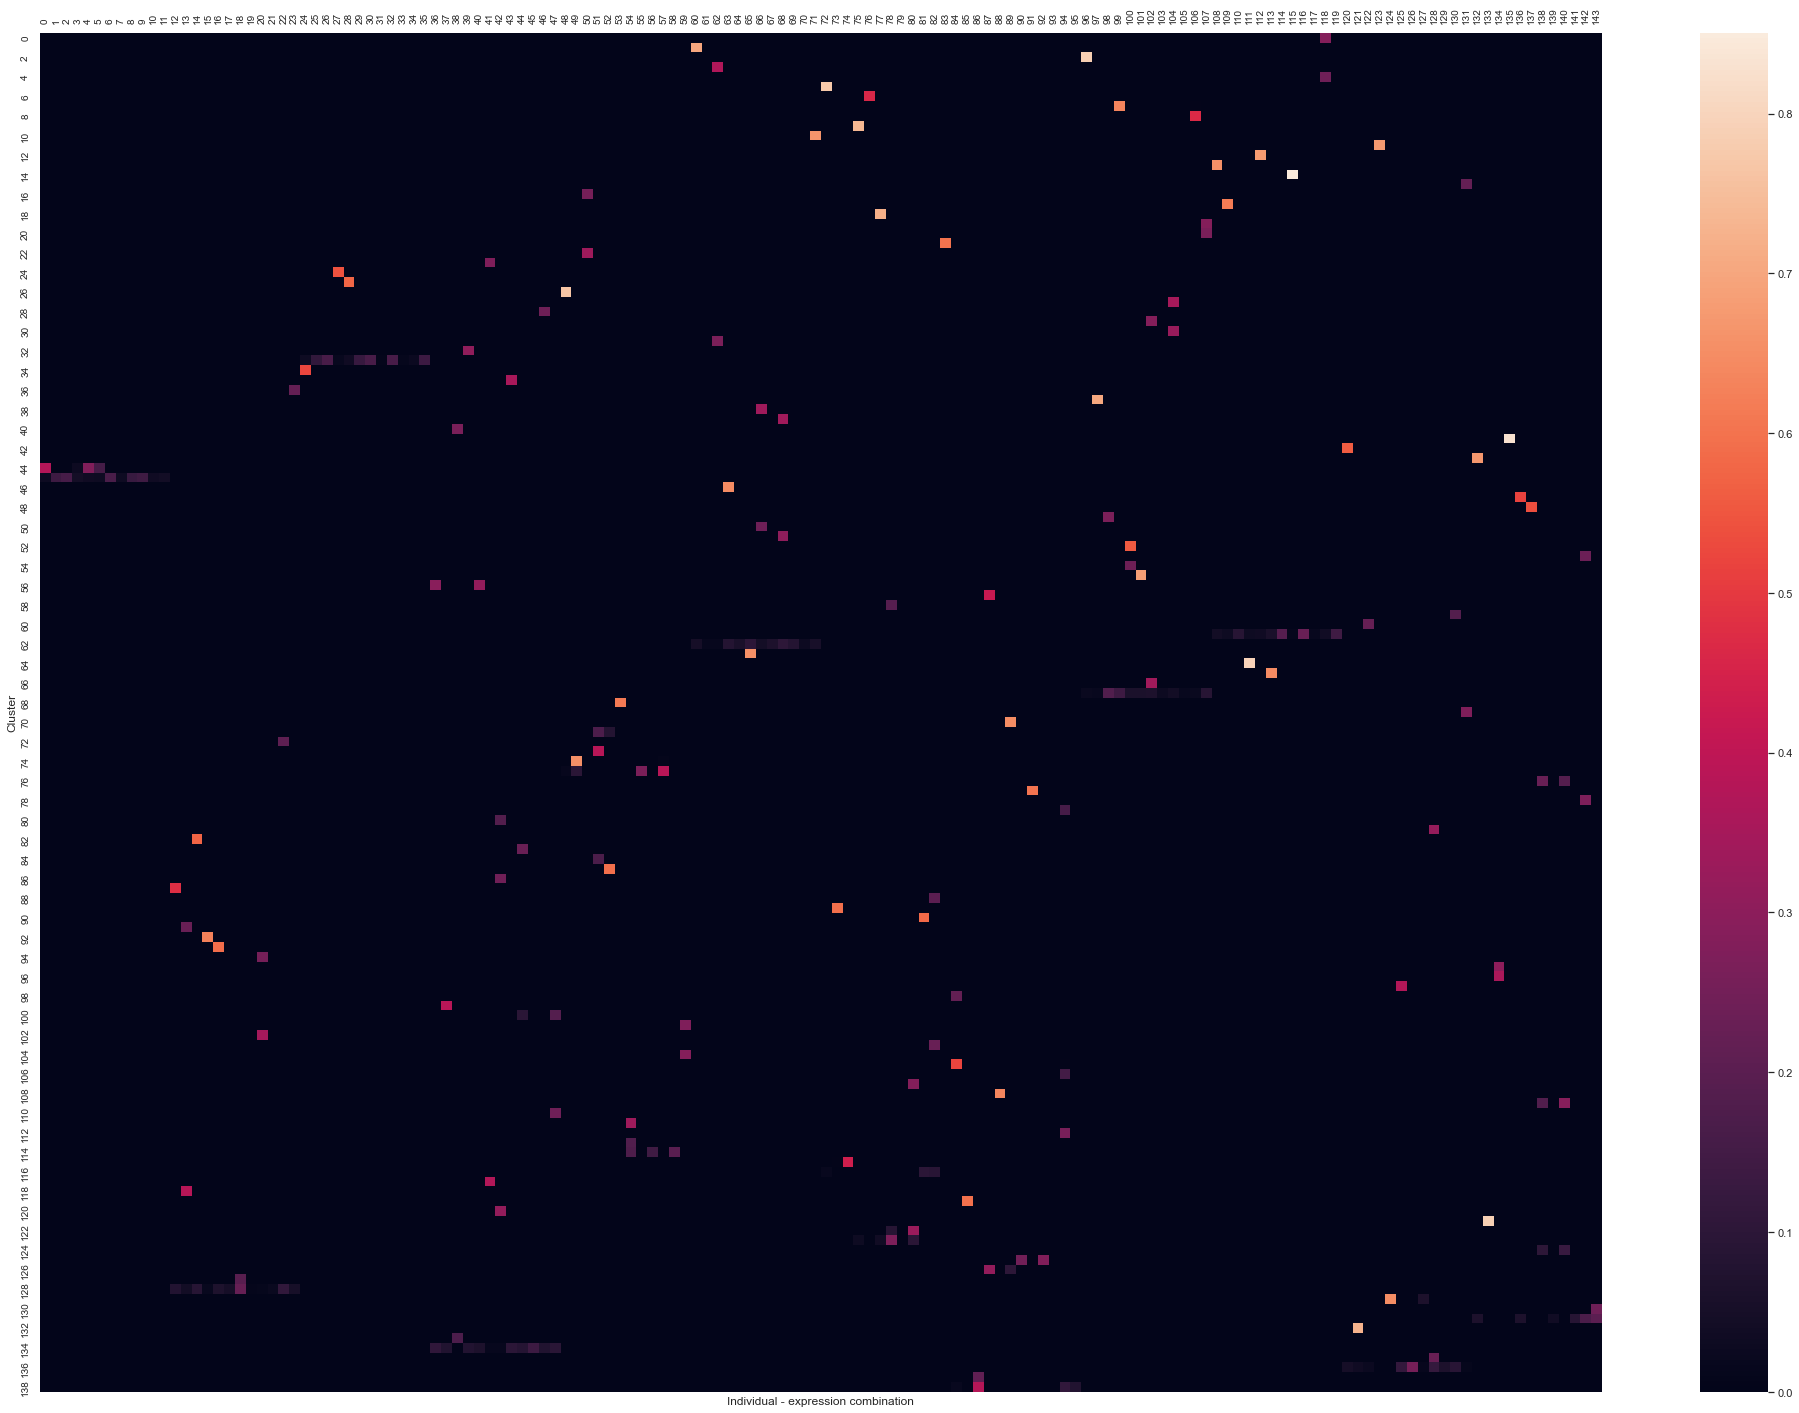

In [58]:
import seaborn as sns
sns.set(rc={'figure.figsize':(35,25)})
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
ax = sns.heatmap(IoUs, annot=False)
ax.set_xlabel("Individual - expression combination")
ax.set_ylabel("Cluster")